## Importing packages

In [1]:
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torchvision.transforms import CenterCrop
from torch.nn import functional as F
from sklearn.model_selection import train_test_split
import torchvision
import numpy as np
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm
import torch
from torchvision.transforms.autoaugment import AutoAugmentPolicy
import time
import os
import cv2
from PIL import Image
import random
import pandas as pd
import scipy.misc as misc


## Using GPU for PyTorch

In [2]:
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False
print(f'Current device is {DEVICE}')


Current device is cuda


## Configuration parameters for segmentation

In [3]:
# base path of the dataset
DATASET_PATH = "ham1000-segmentation-and-classification"

# define the path to the images and masks dataset
IMAGE_DATASET_PATH = os.path.join(DATASET_PATH, "images\\")
MASK_DATASET_PATH = os.path.join(DATASET_PATH, "masks\\")

# define the input image dimensions
INPUT_IMAGE_WIDTH = 128
INPUT_IMAGE_HEIGHT = 128

# define threshold to filter weak predictions
THRESHOLD = 0.4

# define the path to the base output directory
BASE_OUTPUT = "output"

# define the path to the output serialized model
MODEL_PATH = os.path.join(BASE_OUTPUT, "unet_tgs_salt.pth")
TEMP_PATHS = os.path.sep.join([BASE_OUTPUT, "temp_paths.txt"])


## Visualization of dataset classes

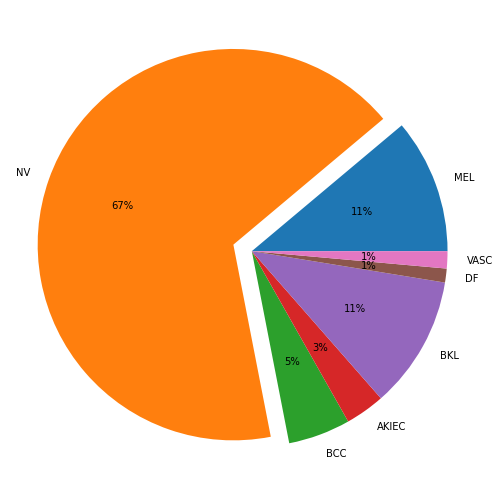

In [4]:
GT = pd.read_csv('ham1000-segmentation-and-classification\\GroundTruth.csv')
gt = GT.sum().to_frame().reset_index().drop(0)
gt.columns = ['toc', 'sum']

plt.figure(figsize=(15,9))
explode = [0, 0.1, 0, 0, 0, 0, 0]
plt.pie(gt['sum'], labels=gt['toc'],explode=explode, autopct='%.0f%%')
plt.show()


## Unet model

In [5]:
class Block(Module):
    def __init__(self, inChannels, outChannels):
        super().__init__()
        # store the convolution and RELU layers
        self.conv1 = Conv2d(inChannels, outChannels, 3)
        self.relu = ReLU()
        self.conv2 = Conv2d(outChannels, outChannels, 3)
    def forward(self, x):
        # apply CONV => RELU => CONV block to the inputs and return it
        return self.conv2(self.relu(self.conv1(x)))

In [6]:
class Encoder(Module):
    def __init__(self, channels=(3, 16, 32, 64)):
        super().__init__()
        # store the encoder blocks and maxpooling layer
        self.encBlocks = ModuleList(
            [Block(channels[i], channels[i + 1])
             for i in range(len(channels) - 1)])
        self.pool = MaxPool2d(2)
        
    def forward(self, x):
        # initialize an empty list to store the intermediate outputs
        blockOutputs = []
        # loop through the encoder blocks
        for block in self.encBlocks:
            # pass the inputs through the current encoder block, store
            # the outputs, and then apply maxpooling on the output
            x = block(x)
            blockOutputs.append(x)
            x = self.pool(x)
            # return the list containing the intermediate outputs
        return blockOutputs                        
                                     

In [7]:
class Decoder(Module):
    def __init__(self, channels=(64, 32, 16)):
        super().__init__()
        # initialize the number of channels, upsampler blocks, and
        # decoder blocks
        self.channels = channels
        self.upconvs = ModuleList(
            [ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
             for i in range(len(channels) - 1)])
        self.dec_blocks = ModuleList(
            [Block(channels[i], channels[i + 1])
             for i in range(len(channels) - 1)])
        
    def forward(self, x, encFeatures):
        # loop through the number of channels
        for i in range(len(self.channels) - 1):
            # pass the inputs through the upsampler blocks
            x = self.upconvs[i](x)
            # crop the current features from the encoder blocks,
            # concatenate them with the current upsampled features,
            # and pass the concatenated output through the current
            # decoder block
            encFeat = self.crop(encFeatures[i], x)
            x = torch.cat([x, encFeat], dim=1)
            x = self.dec_blocks[i](x)
            # return the final decoder output
        return x
      
    def crop(self, encFeatures, x):
        # grab the dimensions of the inputs, and crop the encoder
        # features to match the dimensions
        (_, _, H, W) = x.shape
        encFeatures = CenterCrop([H, W])(encFeatures)
        # return the cropped features
        return encFeatures
    

In [8]:
class UNet(Module):
    def __init__(self,encChannels=(3, 16, 32, 64), decChannels=(64, 32, 16), 
                 nbClasses=1, retainDim=True, 
                 outSize=(INPUT_IMAGE_HEIGHT,  INPUT_IMAGE_WIDTH)):
        super().__init__()
        # initialize the encoder and decoder
        self.encoder = Encoder(encChannels)
        self.decoder = Decoder(decChannels)
        
        # initialize the regression head and store the class variables
        self.head = Conv2d(decChannels[-1], nbClasses, 1)
        self.retainDim = retainDim
        self.outSize = outSize
        
    def forward(self, x):
        # grab the features from the encoder
        encFeatures = self.encoder(x)
        
        # pass the encoder features through decoder making sure that
        # their dimensions are suited for concatenation
        decFeatures = self.decoder(encFeatures[::-1][0], encFeatures[::-1][1:])
        
        # pass the decoder features through the regression head to
        # obtain the segmentation mask
        map = self.head(decFeatures)
        
        # check to see if we are retaining the original output
        # dimensions and if so, then resize the output to match them
        if self.retainDim:
            map = F.interpolate(map, self.outSize)
            
        # return the segmentation map    
        return map

## Functions for making predictions

In [9]:
def prepare_plot_no_mask(origImage, predMask):
    # initialize our figure
    figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
    # plot the original image, its mask, and the predicted mask
    ax[0].imshow(origImage)
    ax[1].imshow(predMask)
    # set the titles of the subplots
    ax[0].set_title("Image")
    ax[1].set_title("Predicted Mask")
    # set the layout of the figure and display it
    figure.tight_layout()
    figure.show()


In [10]:
def make_predictions_no_mask(model, imagePath):
    # set model to evaluation mode
    model.eval()
    # turn off gradient tracking
    with torch.no_grad():
        # load the image from disk, swap its color channels, cast it
        # to float data type, and scale its pixel values
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype("float32") / 255.0
        # resize the image and make a copy of it for visualization
        image = cv2.resize(image, (128, 128))
        orig = image.copy()
        # make the channel axis to be the leading one, add a batch
        # dimension, create a PyTorch tensor, and flash it to the
        # current device
        image = np.transpose(image, (2, 0, 1))
        image = np.expand_dims(image, 0)
        image = torch.from_numpy(image).to(DEVICE)
        # make the prediction, pass the results through the sigmoid
        # function, and convert the result to a NumPy array
        predMask = model(image).squeeze()
        predMask = torch.sigmoid(predMask)
        predMask = predMask.cpu().numpy()
        # filter out the weak predictions and convert them to integers
        predMask = (predMask > THRESHOLD) * 255
        predMask = predMask.astype(np.uint8)
        # prepare a plot for visualization
        prepare_plot_no_mask(orig, predMask)
    return orig, predMask


## Making predictions

[INFO] loading up test image paths...
[INFO] loading up test image paths...
[INFO] load up model...


C:\Users\krybr\miniconda3\envs\inz\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


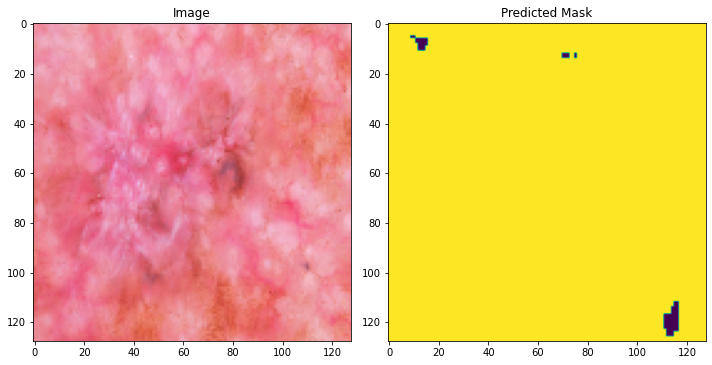

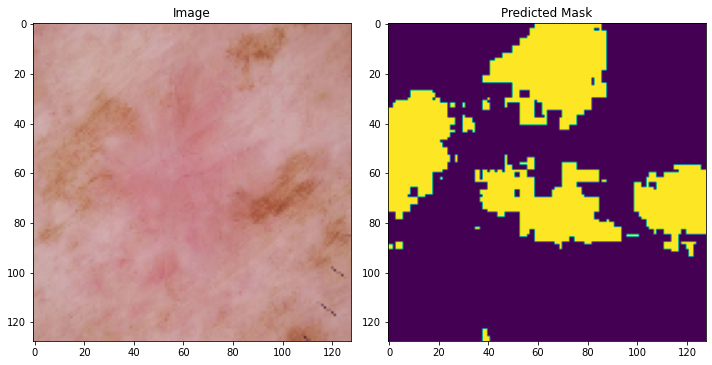

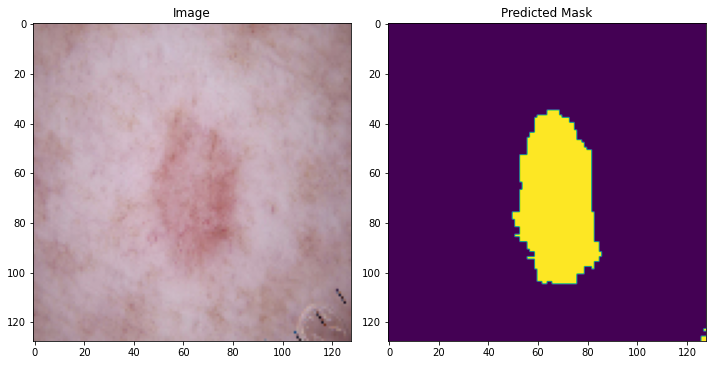

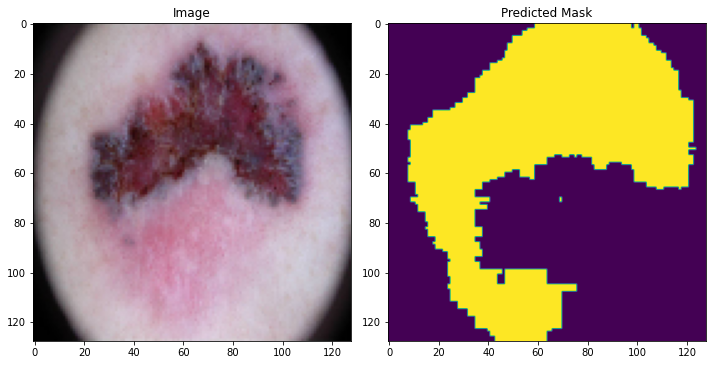

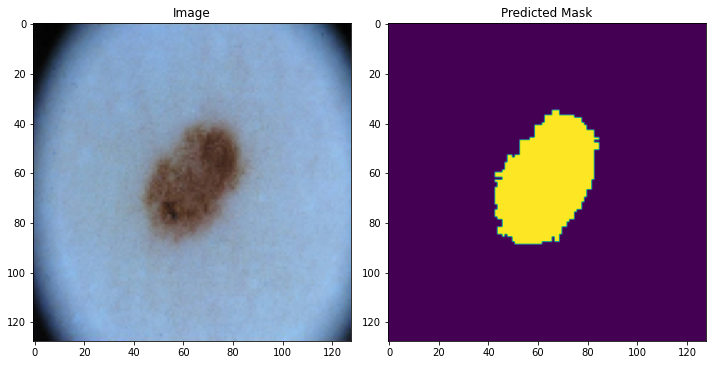

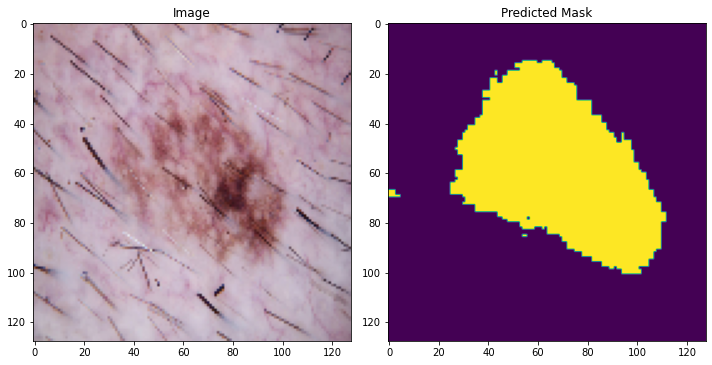

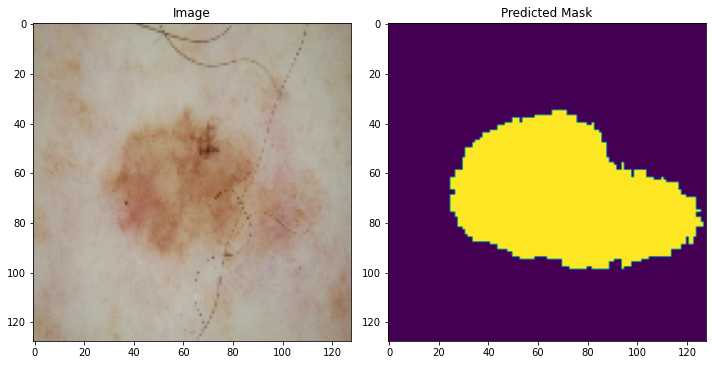

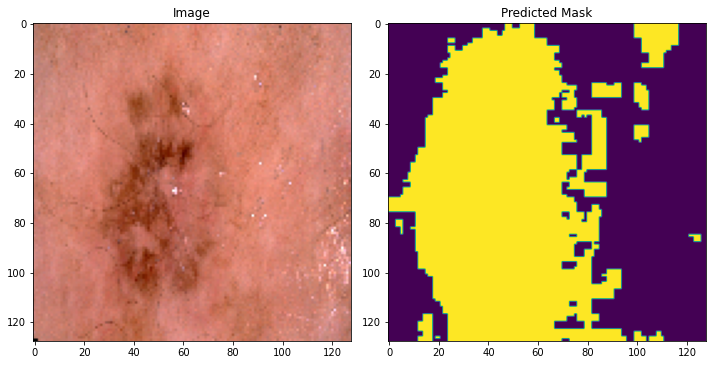

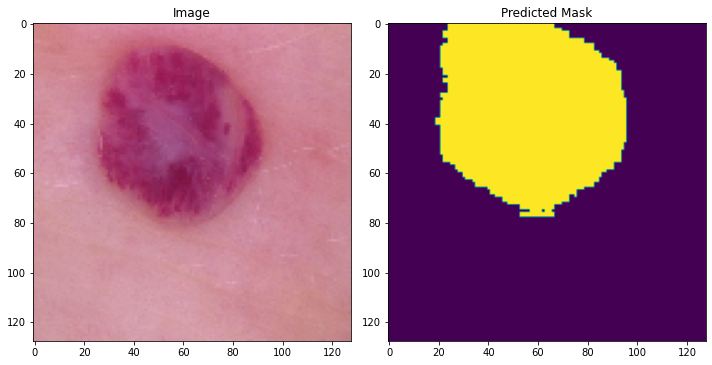

In [11]:
# load the image paths in our testing file and randomly select 10
# image paths
print("[INFO] loading up test image paths...")
FOLDER = 'ib\\'

SUB_FOLDERS = [name for name in os.listdir(FOLDER) if os.path.isdir(os.path.join(FOLDER, name))]

RANDOM_PICTURES = []

# load the image paths in our testing file and randomly select 1 from each category
for folder in SUB_FOLDERS:
    PATH_TO_FOLDER = os.path.join(FOLDER, folder + '\\')
    RANDOM_FROM_FOLDER = random.choice(os.listdir(PATH_TO_FOLDER))
    PATH_TO_RANDOM = os.path.join(FOLDER, folder + '\\', RANDOM_FROM_FOLDER)
    RANDOM_PICTURES.append(PATH_TO_RANDOM)
    
# image paths
orig_images = []
labels = []
print("[INFO] loading up test image paths...")
# load our model from disk and flash it to the current device
print("[INFO] load up model...")
unet = torch.load(MODEL_PATH).to(DEVICE)
# iterate over the randomly selected test image paths
for path in RANDOM_PICTURES:
    # make predictions and visualize the results
    image, label = make_predictions_no_mask(unet, path)
    orig_images.append(image)
    labels.append(label)
    